# RNN Exercises

For these exercises we're using data from the Federal Reserve Economic Database (FRED) concerning Electricity and Gas Utilities Production from January 1992 to January 2019 (325 records).

Data source: https://fred.stlouisfed.org/series/IPG2211A2N

In the exercises below you'll be asked to do the following:
* Perform standard imports, load & plot the dataset
* Prepare data for an LSTM model
* Define the LSTM model, loss and optimization functions
* Train the model
* Evaluate the model on test data
* OPTIONAL: Plot the results

## Steps

Steps to train and predict with the model:

1. Import data
2. Ensure there are no blank or invalid values
3. Understand cycle/seasonality of the data to select the window and future prediction
4. Split train/test data sets
4. Normalise/scale the data
5. Create training windows
6. Define the model
7. Define loss and optimiser
8. Train model
9. Evaluate the model
10. Forecast

# Imports

In [1]:
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Data preprocessing

## Data exploration

In [2]:
# Reat data
df = pd.read_csv('../Data/TimeSeriesData/Energy_Production_Updated.csv',index_col=0,parse_dates=True)

df.iloc[[1,2,-2,-1],:]

,IPG2211A2N
DATE,
1939-02-01,3.3552
1939-03-01,3.4315
2022-02-01,112.0412
2022-03-01,106.4788


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 999 entries, 1939-01-01 to 2022-03-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   IPG2211A2N  999 non-null    float64
dtypes: float64(1)
memory usage: 15.6 KB


Data is already a `float64`. No transforms needed

No blank values found

In [4]:
# Check for nan
df.isna().sum()

IPG2211A2N    0
dtype: int64

<AxesSubplot:xlabel='DATE'>

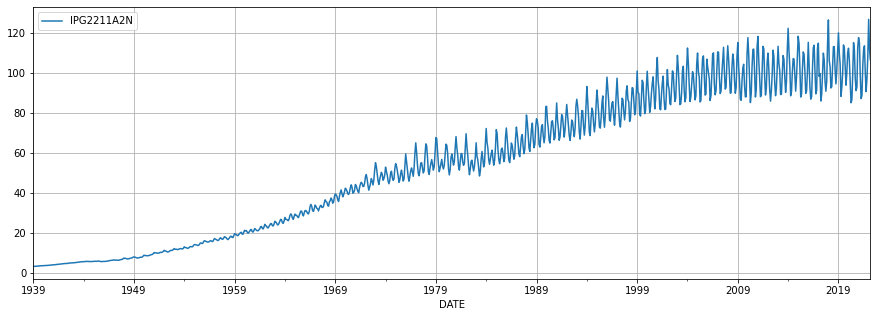

In [5]:
df.plot(figsize=(15,5),grid=True)

There is a significant change in the scale of the values in the data. Initial points are almost an order of magniture smaller than later points.

It would appear that from the 80's seasonality starts playing a part with variability increasing in the cycles as time goes further.

In [6]:
# Add year to data
df['Year'] = df.index.year
df['Month'] = df.index.month

Exploring the entire dataset in 5-year increments from the beginning shows a marked change in the seasonality of the data.

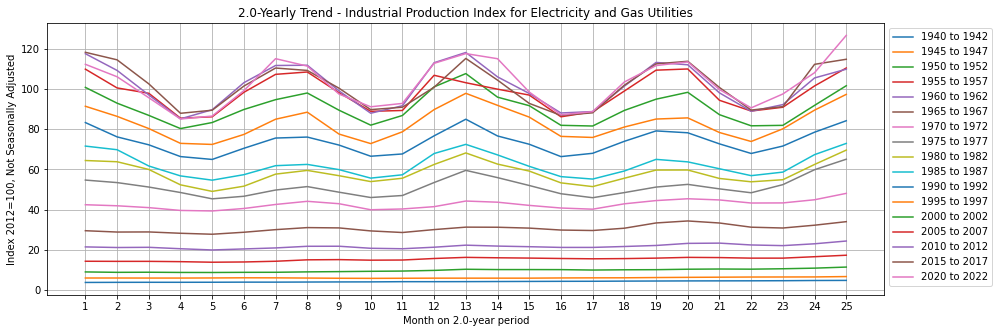

In [7]:
base = pd.to_datetime('1940-01-01')
months = 12*2
x = np.arange(months+1)+1

plt.figure(figsize=(15,5))

for i in np.arange(0,df.index.max().year-df.index.min().year-int(months/12),5):
    start = base+pd.DateOffset(years=i)
    plt.plot(x,df.loc[start:start+pd.DateOffset(months=months)]['IPG2211A2N'], label=f'{start.year} to {start.year + int(months/12)}')
    
title = (months/12)
plt.title(f'{title}-Yearly Trend - Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.xlabel(f'Month on {title}-year period')
plt.xticks(x)
plt.grid()
plt.legend(bbox_to_anchor=(1,1));

More in depth research shows that seasonality

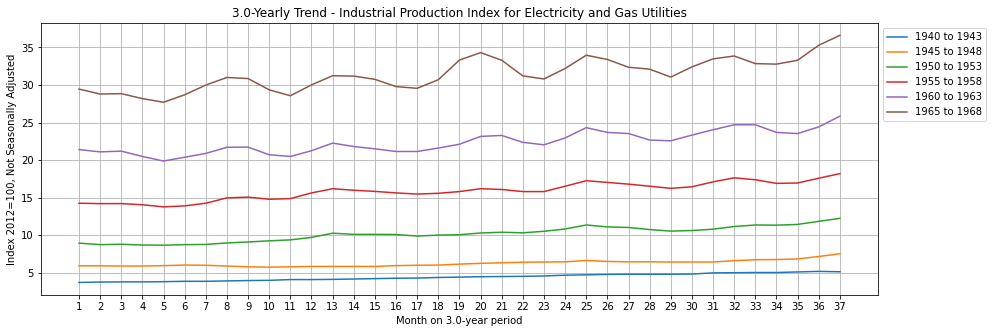

In [8]:
base = pd.to_datetime('1940-01-01')
months = 12*3
x = np.arange(months+1)+1

plt.figure(figsize=(15,5))

for i in np.arange(0,30,5):
    start = base+pd.DateOffset(years=i)
    plt.plot(x,df.loc[start:start+pd.DateOffset(months=months)]['IPG2211A2N'], label=f'{start.year} to {start.year + int(months/12)}')
    
title = (months/12)
plt.title(f'{title}-Yearly Trend - Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.xlabel(f'Month on {title}-year period')
plt.xticks(x)
plt.grid()
plt.legend(bbox_to_anchor=(1,1));

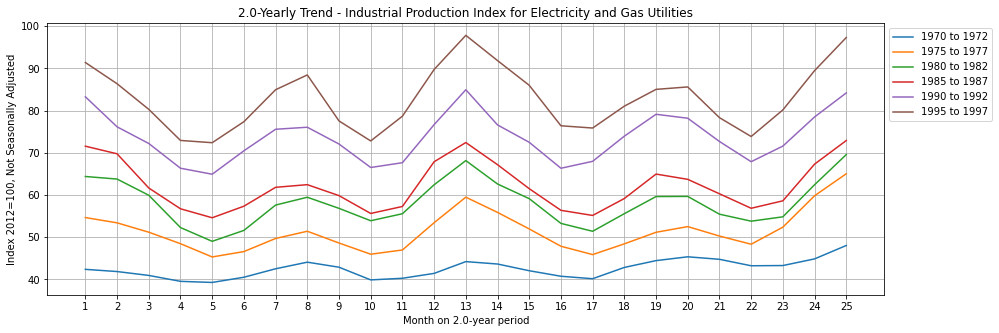

In [9]:
base = pd.to_datetime('1970-01-01')
months = 24
x = np.arange(months+1)+1

plt.figure(figsize=(15,5))

for i in np.arange(0,30,5):
    start = base+pd.DateOffset(years=i)
    plt.plot(x,df.loc[start:start+pd.DateOffset(months=months)]['IPG2211A2N'], label=f'{start.year} to {start.year + int(months/12)}')
    
title = (months/12)
plt.title(f'{title}-Yearly Trend - Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.xlabel(f'Month on {title}-year period')
plt.xticks(x)
plt.grid()
plt.legend(bbox_to_anchor=(1,1));

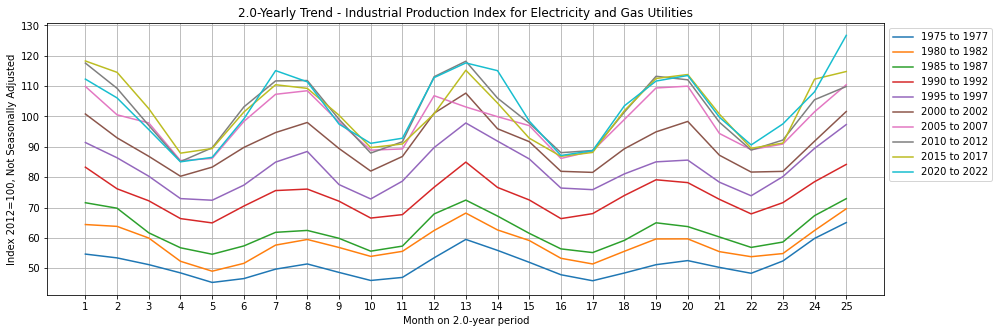

In [10]:
base = pd.to_datetime('1975-01-01')
months = 24
x = np.arange(months+1)+1

plt.figure(figsize=(15,5))

for i in np.arange(0,50,5):
    start = base+pd.DateOffset(years=i)
    plt.plot(x,df.loc[start:start+pd.DateOffset(months=months)]['IPG2211A2N'], label=f'{start.year} to {start.year + int(months/12)}')
    
title = (months/12)
plt.title(f'{title}-Yearly Trend - Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.xlabel(f'Month on {title}-year period')
plt.xticks(x)
plt.grid()
plt.legend(bbox_to_anchor=(1,1));

The seasonality is considerably morem marked from 2000 onwards but recognisable as far back as 1975. Overall we can see the data follows a yearly pattern.

<AxesSubplot:xlabel='Year'>

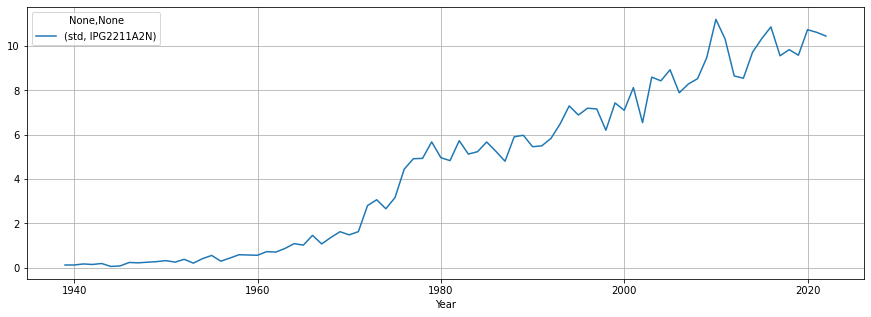

In [11]:
df.pivot_table(index='Year',aggfunc=[np.std],values='IPG2211A2N').plot(figsize=(15,5),grid=True)

<AxesSubplot:xlabel='Year'>

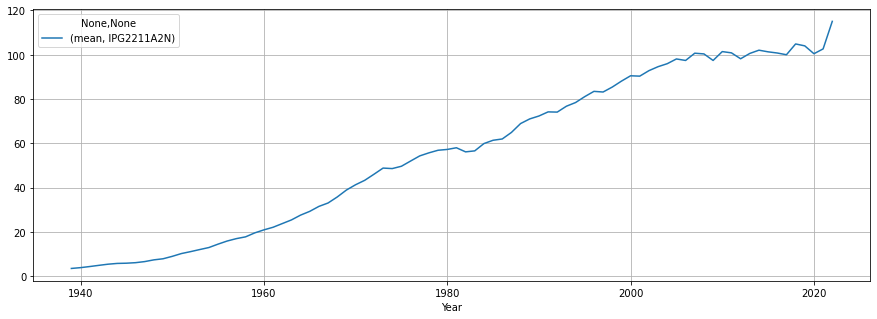

In [12]:
df.pivot_table(index='Year',aggfunc=[np.mean],values='IPG2211A2N').plot(figsize=(15,5),grid=True)

<AxesSubplot:xlabel='Year'>

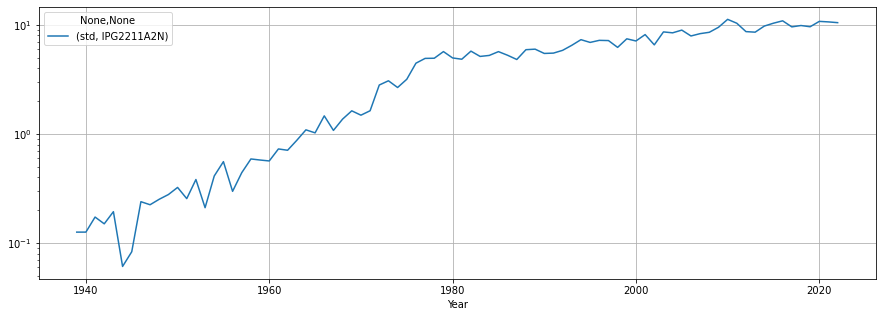

In [13]:
df.pivot_table(index='Year',aggfunc=[np.std],values='IPG2211A2N').plot(figsize=(15,5),grid=True, logy=True)

<AxesSubplot:xlabel='Year'>

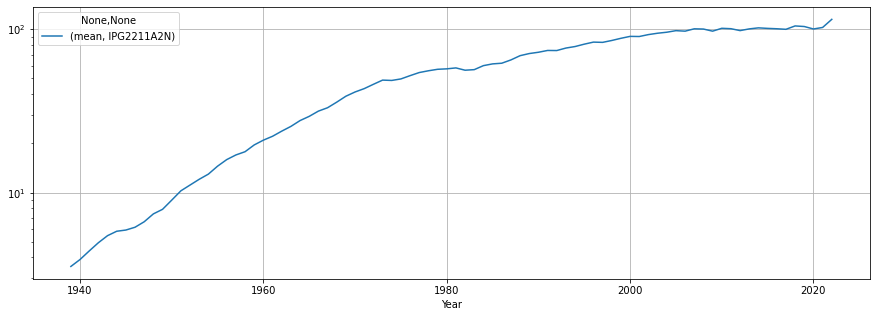

In [14]:
df.pivot_table(index='Year',aggfunc=[np.mean],values='IPG2211A2N').plot(figsize=(15,5),grid=True, logy=True)

Mean industrial production has grown over two orders on magniture from the 40's while its variability has seen an increase of one order of magnitude.

We will be using data from the 90's onwards for training and forecasting purposes initially, then test with the entire data set to see if there is a significant improvement/deterioration of the results.

## Train/test splits

In [15]:
# Extract values

data_start_date = '2000-01-01'

y = df.loc[f'{data_start_date}':]['IPG2211A2N'].values
y.dtype, y.shape

(dtype('float64'), (267,))

In [16]:
# Split to trianing and testing data
window_size = 12

train_set = y[:-window_size]
test_set = y[-window_size:]

print(f'Expected train = {y.shape[0]-window_size}\tActual train = {train_set.shape[0]}')
print(f'Expected test = {window_size}\tActual train = {test_set.shape[0]}')

Expected train = 255	Actual train = 255
Expected test = 12	Actual train = 12


## Data scaling

In [17]:
# Instantiate scaler

feature_range = (-1,1)
scaler = MinMaxScaler(feature_range=(-1,1))

# Reshape data for scaling
train_set = train_set.reshape(-1,1)

In [18]:
train_scl = scaler.fit_transform(train_set)

## Creating training windows

In [19]:
# Convert data to FloatTensor and flatten

train_scl = torch.FloatTensor(train_scl).view(-1)
train_scl.shape, train_scl.dtype

(torch.Size([255]), torch.float32)

In [20]:
def input_data(seq, ws, l=1):
    '''
    Creates the windows of data that will be used for training.
    '''
    out = []
    for i in range(len(seq)-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+l]
        out.append((window,label))
    return out

In [21]:
# Create training windows

train_data = input_data(train_scl,window_size)
print(f'Expected = {y.shape[0]-window_size*2}\tActual = {len(train_data)}')

Expected = 243	Actual = 243


In [22]:
train_data[0]

(tensor([-0.1104, -0.4514, -0.7150, -1.0000, -0.8695, -0.5877, -0.3756, -0.2317,
         -0.6035, -0.9261, -0.7174, -0.0992]),
 tensor([0.1873]))

# Model definition

## Define the model

In [23]:
class LSTMmodel(nn.Module):
    
    def __init__(self, input_sz=1, hidden_sz=100, output_sz=1, ltsm_layers=1):
        super().__init__()
        
        self.hidden_sz = hidden_sz
        
        # Add LSTM layer
        self.lstm = nn.LSTM(input_sz, hidden_sz, ltsm_layers)
      
        # Add a fully connected layer
        self.fc1 = nn.Linear(hidden_sz, output_sz)
        
        # Initialise hidden (h_0) and cell (c_0) states
        self.hidden = (torch.zeros(1,1,self.hidden_sz),
                       torch.zeros(1,1,self.hidden_sz))
        
    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        pred = self.fc1(lstm_out.view(len(seq),-1))
        return pred[-1]

## Define loss and optimiser

In [24]:
model = LSTMmodel()

criterion = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters())

model

LSTMmodel(
  (lstm): LSTM(1, 100)
  (fc1): Linear(in_features=100, out_features=1, bias=True)
)

# Training

In [25]:
epochs = 100

start_time = time.time()

for i in range(epochs):
    
    for seq, y_train in train_data:
        
        # Reset hidden states and optimiser
        optimiser.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_sz),
                        torch.zeros(1,1,model.hidden_sz))
        
        # Get predictions
        y_pred = model(seq)
        
        # Calculate loss and backpropagate
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimiser.step()
        
    if i%10==0:
        print(f'Epoch: {i:3}\tLoss: {loss:8.5f}')

print(f'Training time: {(time.time()-start_time)/60:.2f} mins')

Epoch:   0	Loss:  0.00548
Epoch:  10	Loss:  0.01253
Epoch:  20	Loss:  0.03291
Epoch:  30	Loss:  0.04007
Epoch:  40	Loss:  0.04264
Epoch:  50	Loss:  0.04798
Epoch:  60	Loss:  0.06438
Epoch:  70	Loss:  0.04650
Epoch:  80	Loss:  0.02141
Epoch:  90	Loss:  0.00015
Training time: 0.86 mins


# Evaluating the model

In [26]:
# Window to look into the future
future = 12

# Select the last window from the training set to predict known data
preds = train_scl[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    
    with torch.no_grad():
        # Reset hidden states
        model.hidden = (torch.zeros(1,1,model.hidden_sz),
                        torch.zeros(1,1,model.hidden_sz))
        preds.append(model(seq).item())

In [27]:
# Inverse scaler
preds_inv = scaler.inverse_transform(np.array(preds[-future:]).reshape(-1,1))
preds_inv

array([[ 89.75183803],
       [ 93.97137146],
       [107.4219641 ],
       [117.13799069],
       [109.81847331],
       [103.20981214],
       [ 93.17766599],
       [ 97.83796607],
       [106.92804802],
       [113.4860062 ],
       [108.99561225],
       [100.52776251]])

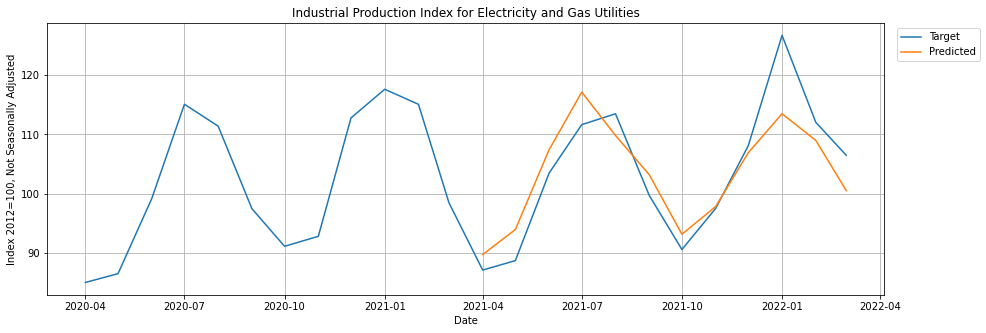

In [28]:
plt.figure(figsize=(15,5))

plt.plot(df.iloc[-24:]['IPG2211A2N'],label='Target')
plt.plot(df.iloc[-12:].index,preds_inv,label='Predicted')
    
plt.title(f'Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.xlabel(f'Date')
plt.legend(bbox_to_anchor=(1.12,1));
plt.grid();
plt.savefig(f'{data_start_date} start result - scaling {feature_range}.png')

# Forecasting

To forecast we will:
1. Scale the data
2. Create training windows
3. Train the model
4. Forecast, denormalise, and plot values

In [29]:
# Scale entirety of the data

scaler = MinMaxScaler(feature_range=feature_range)

data_scaled = scaler.fit_transform(y.reshape(-1,1))
data_scaled.shape

(267, 1)

In [30]:
# Transform to tensor and flatten
data_scaled = torch.FloatTensor(data_scaled).view(-1)
data_scaled.shape

torch.Size([267])

In [32]:
# Create training windows
all_data = input_data(data_scaled,window_size)
print(f'Expected = {len(y)-window_size}\tActual = {len(all_data)}')

Expected = 255	Actual = 255


In [33]:
epochs = 100

model.train()

start_time = time.time()

for i in range(epochs):
    
    for seq, y in all_data:
        
        # Reset hidden states and optimiser
        optimiser.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_sz),
                        torch.zeros(1,1,model.hidden_sz))
        
        # Get predictions
        pred = model(seq)
        
        # Calculate loss and backpropagate
        loss = criterion(pred, y)
        loss.backward()
        optimiser.step()
        
    if i%10==0:
        print(f'Epoch: {i:3}\tLoss: {loss:8.5f}')
print(f'Epoch: {i:3}\tLoss: {loss:8.5f}')

print(f'Training time: {(time.time()-start_time)/60:.2f} mins')

Epoch:   0	Loss:  0.00751
Epoch:  10	Loss:  0.02387
Epoch:  20	Loss:  0.00143
Epoch:  30	Loss:  0.00564
Epoch:  40	Loss:  0.00019
Epoch:  50	Loss:  0.02423
Epoch:  60	Loss:  0.00014
Epoch:  70	Loss:  0.01112
Epoch:  80	Loss:  0.00025
Epoch:  90	Loss:  0.00001
Epoch:  99	Loss:  0.00297
Training time: 0.98 mins


In [45]:
# Forecast new values
future = 12

preds = data_scaled[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_sz),
                        torch.zeros(1,1,model.hidden_sz))
        pred = model(seq).item()
        preds.append(pred)

In [52]:
# Invert normalisation
preds_inv = scaler.inverse_transform(np.array(preds[-future:]).reshape(-1,1))

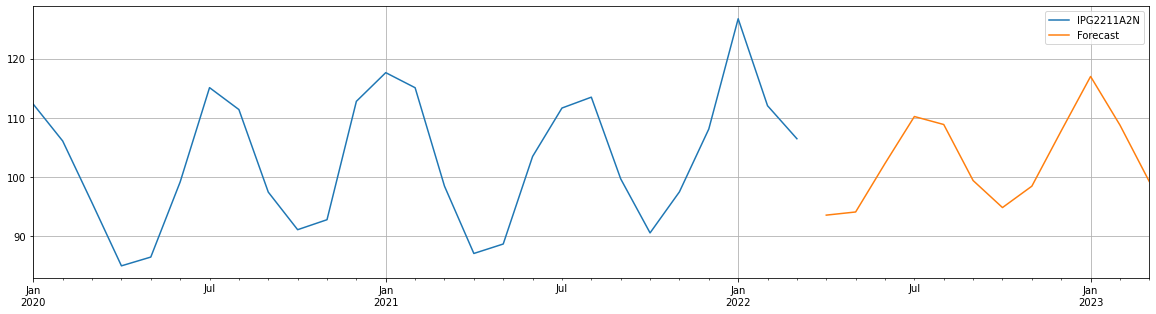

In [59]:
# Plot results
x = np.arange(start=df.iloc[-1].name+pd.DateOffset(months=1),stop=df.iloc[-1].name+pd.DateOffset(months=future+1),dtype='datetime64[M]').astype('datetime64[D]')
forecast_df = pd.concat([df[['IPG2211A2N']],pd.DataFrame({'Forecast':preds_inv.reshape(-1)}, index=x)])

# Plot results
forecast_df.loc['2020-01-01':].plot(figsize=(20,5))
plt.grid()